# Tutorial: Two dimensional Darcy flow using the Fourier Neural Operator

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial5/tutorial.ipynb)


In this tutorial we are going to solve the Darcy flow problem in two dimensions, presented in [*Fourier Neural Operator for
Parametric Partial Differential Equation*](https://openreview.net/pdf?id=c8P9NQVtmnO). First of all we import the modules needed for the tutorial. Importing `scipy` is needed for input-output operations.

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab"
    !pip install scipy
    # get the data
    !wget https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial5/Data_Darcy.mat

import torch
import matplotlib.pyplot as plt
import warnings

# !pip install scipy  # install scipy
from scipy import io
from pina.model import FNO, FeedForward  # let's import some models
from pina import Condition, Trainer
from pina.solver import SupervisedSolver
from pina.problem.zoo import SupervisedProblem

warnings.filterwarnings("ignore")

## Data Generation

We will focus on solving a specific PDE, the **Darcy Flow** equation. The Darcy PDE is a second-order elliptic PDE with the following form:

$$
-\nabla\cdot(k(x, y)\nabla u(x, y)) = f(x) \quad (x, y) \in D.
$$

Specifically, $u$ is the flow pressure, $k$ is the permeability field and $f$ is the forcing function. The Darcy flow can parameterize a variety of systems including flow through porous media, elastic materials and heat conduction. Here you will define the domain as a 2D unit square Dirichlet boundary conditions. The dataset is taken from the authors original reference.


In [2]:
# download the dataset
data = io.loadmat("Data_Darcy.mat")

# extract data (we use only 100 data for train)
k_train = torch.tensor(data["k_train"], dtype=torch.float)
u_train = torch.tensor(data["u_train"], dtype=torch.float)
k_test = torch.tensor(data["k_test"], dtype=torch.float)
u_test = torch.tensor(data["u_test"], dtype=torch.float)
x = torch.tensor(data["x"], dtype=torch.float)[0]
y = torch.tensor(data["y"], dtype=torch.float)[0]

Let's visualize some data

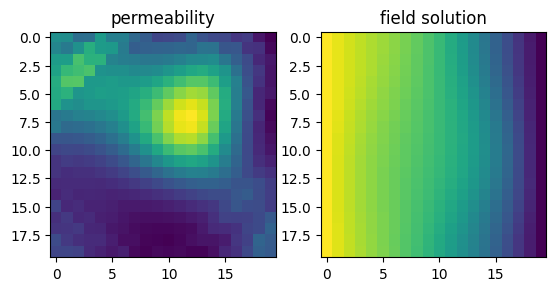

In [3]:
plt.subplot(1, 2, 1)
plt.title("permeability")
plt.imshow(k_train[0])
plt.subplot(1, 2, 2)
plt.title("field solution")
plt.imshow(u_train[0])
plt.show()

We now create the Neural Operators problem class. Learning Neural Operators is similar as learning in a supervised manner, therefore we will use `SupervisedProblem`.

In [4]:
# make problem
problem = SupervisedProblem(
    input_=k_train.unsqueeze(-1), output_=u_train.unsqueeze(-1)
)

## Solving the problem with a FeedForward Neural Network

We will first solve the problem using a Feedforward neural network. We will use the `SupervisedSolver` for solving the problem, since we are training using supervised learning.

In [5]:
# make model
model = FeedForward(input_dimensions=1, output_dimensions=1)


# make solver
solver = SupervisedSolver(problem=problem, model=model, use_lt=False)

# make the trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=False,
    batch_size=10,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 289.72it/s, v_num=3, data_loss_step=0.102, train_loss_step=0.102, data_loss_epoch=0.105, train_loss_epoch=0.105]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 286.77it/s, v_num=3, data_loss_step=0.102, train_loss_step=0.102, data_loss_epoch=0.105, train_loss_epoch=0.105]


The final loss is pretty high... We can calculate the error by importing `LpLoss`.

In [6]:
from pina.loss import LpLoss

# make the metric
metric_err = LpLoss(relative=False)

model = solver.model
err = (
    float(
        metric_err(u_train.unsqueeze(-1), model(k_train.unsqueeze(-1))).mean()
    )
    * 100
)
print(f"Final error training {err:.2f}%")

err = (
    float(metric_err(u_test.unsqueeze(-1), model(k_test.unsqueeze(-1))).mean())
    * 100
)
print(f"Final error testing {err:.2f}%")

Final error training 28.57%
Final error testing 28.59%


## Solving the problem with a Fourier Neural Operator (FNO)

We will now move to solve the problem using a FNO. Since we are learning operator this approach is better suited, as we shall see.

In [7]:
# make model
lifting_net = torch.nn.Linear(1, 24)
projecting_net = torch.nn.Linear(24, 1)
model = FNO(
    lifting_net=lifting_net,
    projecting_net=projecting_net,
    n_modes=8,
    dimensions=2,
    inner_size=24,
    padding=8,
)


# make solver
solver = SupervisedSolver(problem=problem, model=model, use_lt=False)

# make the trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=False,
    batch_size=10,
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 36.66it/s, v_num=4, data_loss_step=0.00164, train_loss_step=0.00164, data_loss_epoch=0.00229, train_loss_epoch=0.00229]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 36.56it/s, v_num=4, data_loss_step=0.00164, train_loss_step=0.00164, data_loss_epoch=0.00229, train_loss_epoch=0.00229]


We can clearly see that the final loss is lower. Let's see in testing.. Notice that the number of parameters is way higher than a `FeedForward` network. We suggest to use GPU or TPU for a speed up in training, when many data samples are used.

In [8]:
model = solver.model
err = (
    float(
        metric_err(u_train.unsqueeze(-1), model(k_train.unsqueeze(-1))).mean()
    )
    * 100
)
print(f"Final error training {err:.2f}%")

err = (
    float(metric_err(u_test.unsqueeze(-1), model(k_test.unsqueeze(-1))).mean())
    * 100
)
print(f"Final error testing {err:.2f}%")

Final error training 3.36%
Final error testing 3.54%


As we can see the loss is way lower!

## What's next?

We have made a very simple example on how to use the `FNO` for learning neural operator. Currently in **PINA** we implement 1D/2D/3D cases. We suggest to extend the tutorial using more complex problems and train for longer, to see the full potential of neural operators.